tl;dr Take a VAE, constraint mean so that 0 covariance, get tuning-free disentanglement (or so it claimed)

paper: https://arxiv.org/abs/1906.11732

credit to original author for advice on implementation

1.Libraries and dataset




---



In [0]:
%pylab inline
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import FashionMNIST

import random

SEED = 1
BATCH_SIZE = 128
cuda = torch.cuda.is_available()
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    
train = FashionMNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

dataloader_args = dict()# if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, shuffle=True, batch_size=BATCH_SIZE,num_workers=4, pin_memory=True)
test_loader = dataloader.DataLoader(test, shuffle=False, batch_size=BATCH_SIZE,num_workers=4, pin_memory=True)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


2. Define Model

In [0]:
Z_DIM = 3
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.Linear(784, 512), nn.ReLU(),
                        nn.Linear(512, 256), nn.ReLU(),
                         nn.Linear(256, 64), nn.ReLU())
        self.fc_mu = nn.Linear(64, Z_DIM)
        self.fc_logvar = nn.Linear(64, Z_DIM)
        self.decoder = nn.Sequential(
                        nn.Linear(Z_DIM, 64), nn.ReLU(),
                        nn.Linear(64, 256), nn.ReLU(),
                         nn.Linear(256, 512), nn.ReLU(),
                         nn.Linear(512, 784), nn.Sigmoid())


    def encode(self, x):
        h1 = self.encoder(x)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
 
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        mu = self.standardize(mu)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar
      
    def standardize(self, mu):
        mu_mu = mu.mean(0, keepdim=True)
        z1 = mu - mu_mu
        cov = z1.t() @ (z1/z1.size(0))
        D = torch.sqrt(torch.diag(torch.diag(cov)))
        L = torch.inverse(torch.cholesky(cov).t())
        z2 = z1 @ L @ D + mu_mu
        return z2

model = VAE().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)

Initial model
PCA explained ratio 0.783783495426178


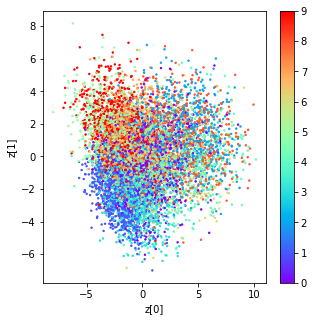

====> Epoch: 1 Average loss: 39.8202
====> Test set loss: 30.4047
PCA explained ratio 0.718276858329773


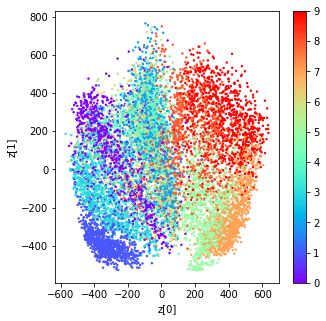

====> Epoch: 2 Average loss: 29.5642
====> Test set loss: 28.7382
PCA explained ratio 0.6934952735900879


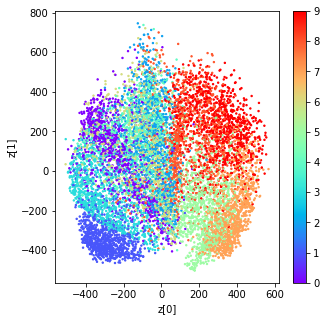

====> Epoch: 3 Average loss: 28.2675
====> Test set loss: 27.6685
PCA explained ratio 0.722571849822998


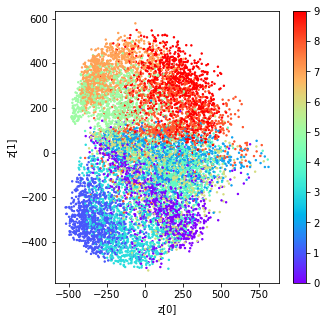

====> Epoch: 4 Average loss: 27.6213
====> Test set loss: 27.0787
PCA explained ratio 0.7317268252372742


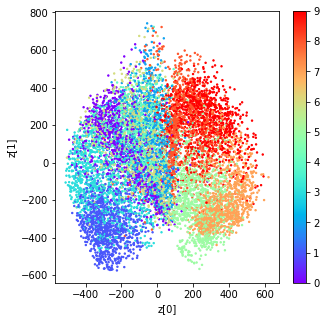

====> Epoch: 5 Average loss: 27.0325
====> Test set loss: 26.7293
PCA explained ratio 0.7248091697692871


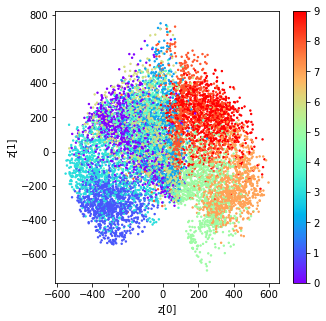

====> Epoch: 6 Average loss: 26.4797
====> Test set loss: 26.0753
PCA explained ratio 0.724949061870575


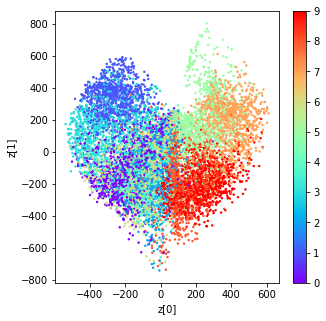

====> Epoch: 7 Average loss: 26.1098
====> Test set loss: 26.1132
PCA explained ratio 0.7168354988098145


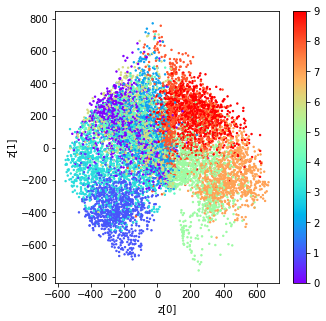

====> Epoch: 8 Average loss: 25.8129
====> Test set loss: 25.6694
PCA explained ratio 0.7191488742828369


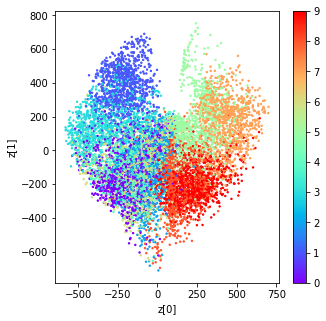

====> Epoch: 9 Average loss: 25.5993
====> Test set loss: 25.4549
PCA explained ratio 0.7368943691253662


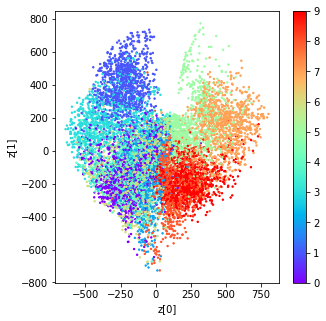

====> Epoch: 10 Average loss: 25.4132
====> Test set loss: 25.5103
PCA explained ratio 0.7352575063705444


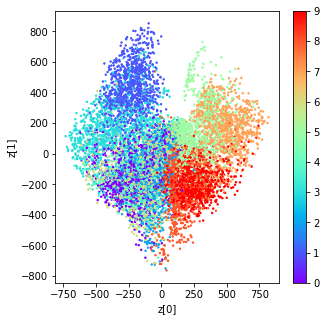

In [0]:
def loss_function(recon_x, x, mu, logvar):
    # recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    recon_loss = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD

LOG_INTERVAL = 50
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)),end='')

    print('\r====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.cuda()
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
from sklearn.decomposition import PCA

def plot_z_mean(model, test_loader, model_name="vae_mnist"):
    x_test = Variable(test_loader.dataset.data.type_as(torch.FloatTensor()))
    y_test = Variable(test_loader.dataset.targets)
    
    model.eval()

    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "z_mean_plot.png")
    with torch.no_grad():
      recon, z_mean, z_std = model(x_test.cuda())
      z_mean = z_mean.cpu().numpy()
    
    pca = PCA(n_components=2)
    pca.fit(z_mean)
    print('PCA explained ratio {}'.format(sum(pca.explained_variance_ratio_))) 
    z_mean = pca.transform(z_mean)

    plt.figure(figsize=(5, 5))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], 
                c=y_test.numpy(), s=2,
                cmap='rainbow')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()


# train
EPOCHS = 10
print("Initial model")
plot_z_mean(model, test_loader)
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)
    plot_z_mean(model, test_loader)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


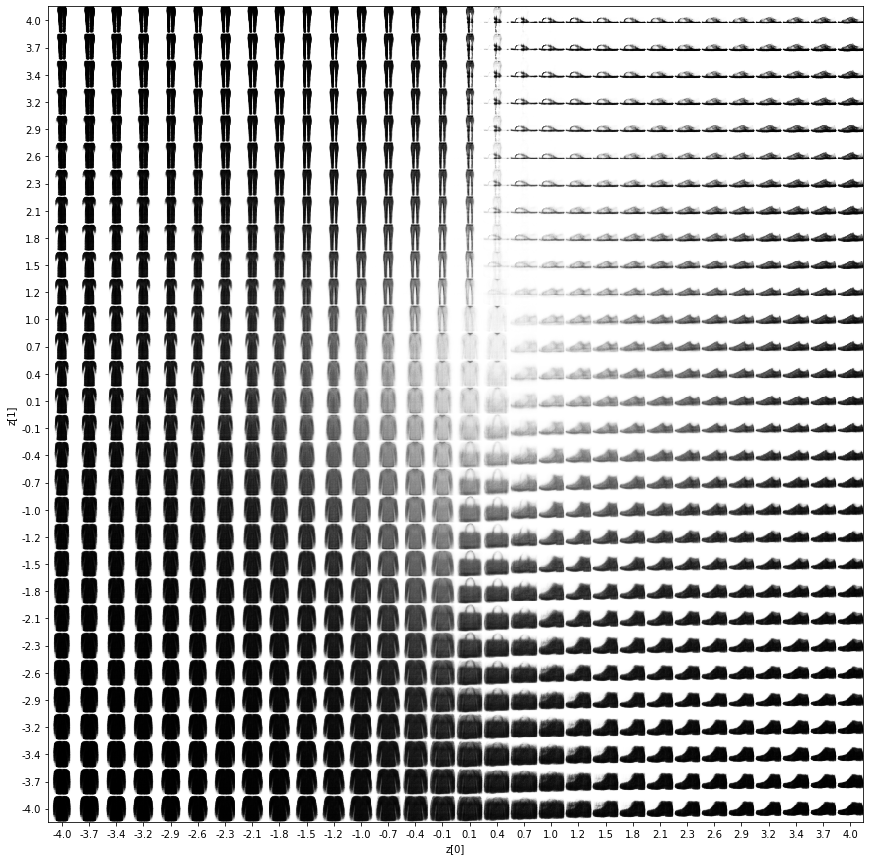

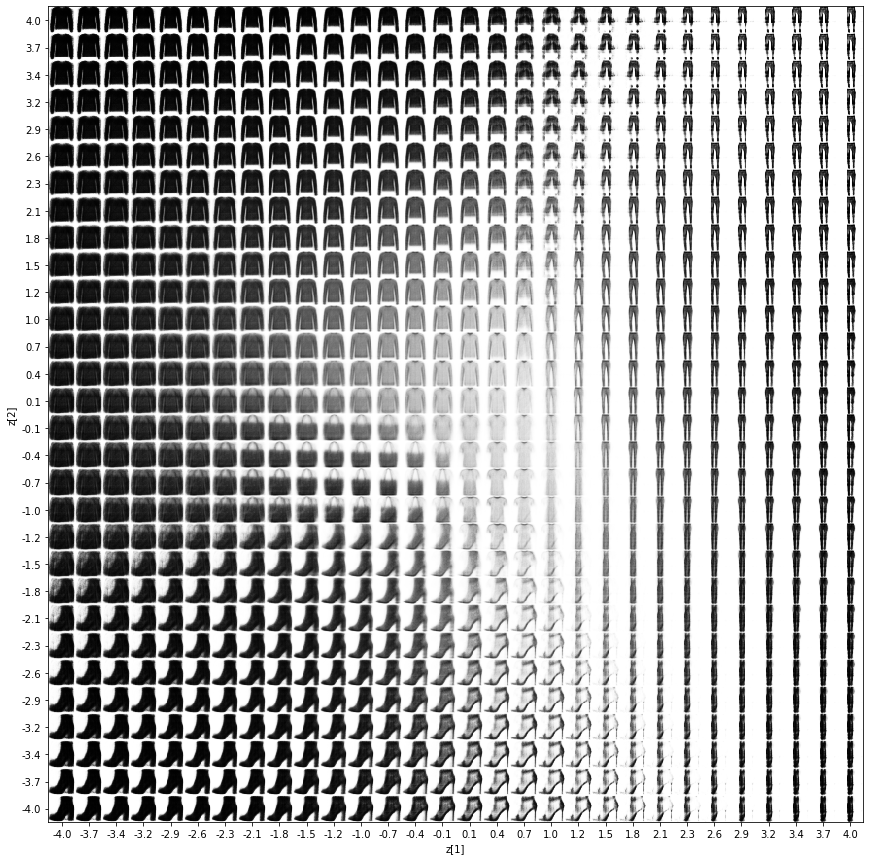

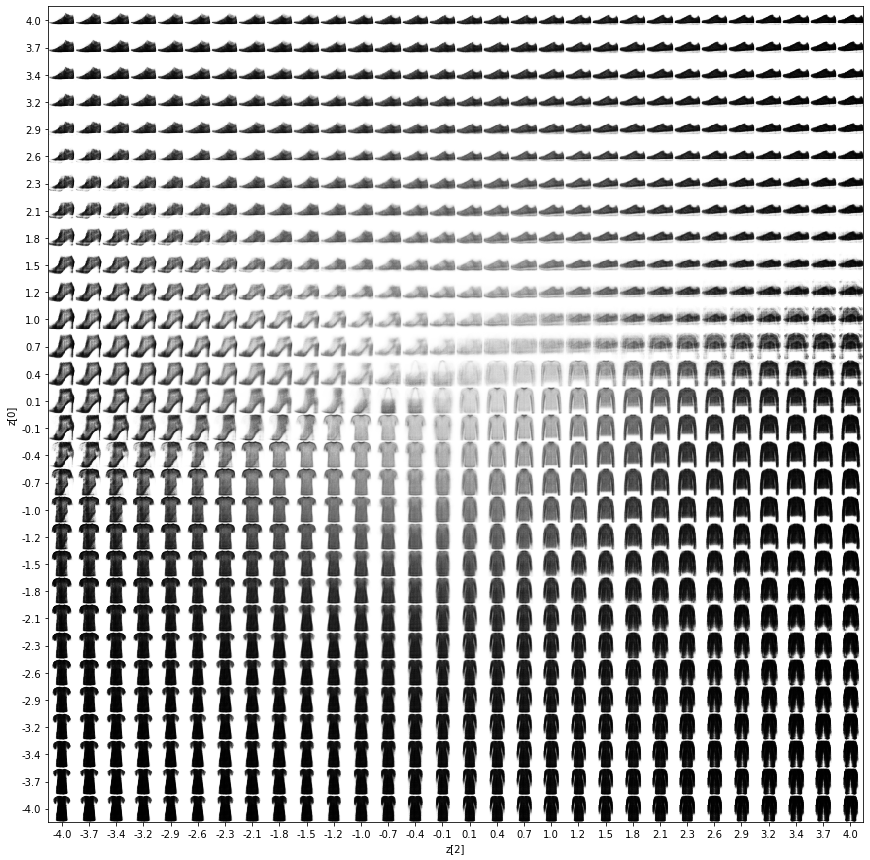

In [0]:
def plot_decoded(model, nouts=7, bound=4, dim1=0, dim2=1, constant=0,
                 model_name="vae_mnist"):
    x_test = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor())).cuda()
    y_test = Variable(test_loader.dataset.test_labels).cuda()
    model.eval()

    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "z_traverse.png")
    digit_size = 28
    figure = np.zeros((digit_size * nouts, digit_size * nouts))
    grid_x = np.linspace(-bound, bound, nouts)
    grid_y = np.linspace(-bound, bound, nouts)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.zeros(Z_DIM).cuda().fill_(constant)
            z_sample[dim1] = xi
            z_sample[dim2] = yi
            x_decoded = model.decode(z_sample)
            with torch.no_grad():
                digit = x_decoded.reshape(digit_size, digit_size).cpu().numpy()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = -digit
    plt.figure(figsize=(15, 15))
    start_range = digit_size // 2
    end_range =  nouts * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[{}]".format(dim1))
    plt.ylabel("z[{}]".format(dim2))
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

# ref = 0
# for i in range(2):
#   if i==ref: continue
#   plot_decoded(model, test_loader, dim1=ref, dim2=i)
plot_decoded(model, test_loader, nouts=30, dim1=0, dim2=1)
plot_decoded(model, test_loader, nouts=30, dim1=1, dim2=2)
plot_decoded(model, test_loader, nouts=30, dim1=2, dim2=0)
